### Antes de falar sobre o assunto

É importante lembrar que, nem sempre modelos mais complexos vão ter um desempenho melhor do que modelos simples.
Isso fica evidente em casos de <strong>overfitting</strong> e <strong>underfitting</strong>. 

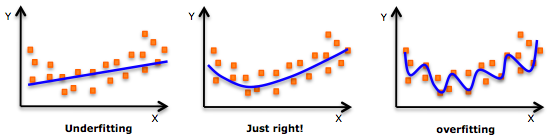

Um modelo que tem overfitting apresenta alta variância e um baixa tendência. Se imaginarmos a tendência como o próprio nome indica, observamos que na firgura o primeiro e segundo modelo tem uma tendência crescente. Já o último, varia tanto que não da pra saber se vai continuar subindo ou não.

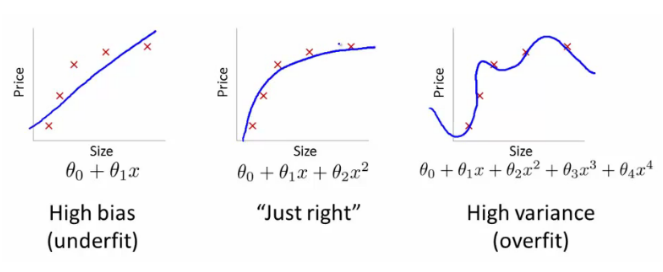

Outro problema que envolve também como o modelo enxerga os dados, é o underfitting. Nesse caso, o modelo não funciona bem nem para os dados de treinamento ou para os dados de teste (novos dados). É um modelo que não consegue generalizar.

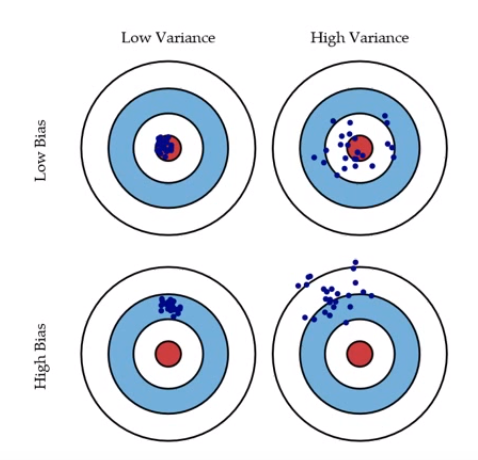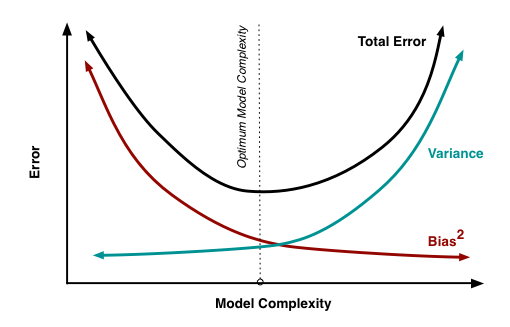

Para entender melhor o conceito de variância e bias, é só olhar a figura acima. Maior a variância, mais descentralizado são os dados. Ou seja, mais eles variam do alvo. Maior o bias, mais longe ele está do alvo.

Para resolver o bias alto ou underfitting, basta adicionar novos parâmetros ao nosso modelo, tornando-o mais complexo.
Para resolver overfitting, devemos buscar deixar o modelo mais simples, ou trabalhar com <strong>regularização</strong>.

### Regressão Polinomial.

Uma regressão polinômial é aquele que tem a forma de polinômio. (Y =Θ1 +Θ2*x +Θ3*x2)
É fácil de pensar que esta pode ser usada em modelos que não são bem representados por uma simples linha.
É por este motivo que é importante se fazer um estudo dos dados antes de aplicar algum modelo. Pois saber como os dados se comportam é fundamental na escolha do modelo.

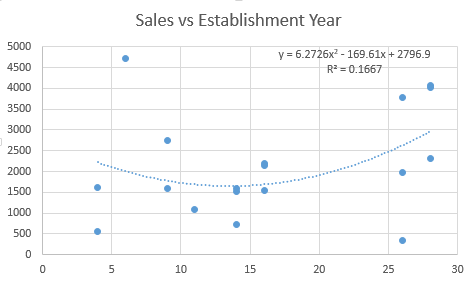

### Regularizando...

Como já foi visto, nosso modelo sofria de hiperestaticidade. Isso significa que ele tinha uma variância que não era constante. 
Mesmo trabalhando em escala logaritmicas nas características numéricas, não consiguimos tornar o modelo mais preciso que o que era antes. 
Vimos entretanto, que o modelo não apresentou problemas como multicolinearidade. O que é bom, ou pelo menos indica menos trablho nos dados. 
E por ultimo, vimos agora que podemos nos livrar de alta variância com o que chamamos de regularização. A regularização, vai basicamente diminuir a magnitude dos coeficientes.

Como assim ? Para entender vamos checar a magnitude dos coeficientes.

In [15]:
import pandas as pd
import sklearn as sk
from sklearn.metrics import mean_squared_error
import random
import warnings
warnings.filterwarnings('ignore')
#Lendo os dados
data = pd.read_csv('./datasets/big_mart_sales/train.csv')
mask = [True if random.random() <= .7 else False for i in range(data.shape[0])]
reverse_mask = [False if isTrue else True for isTrue in mask]
test_data = pd.read_csv('./datasets/big_mart_sales/test.csv')
#imputing missing values
data['Outlet_Size'].fillna('Small',inplace=True)
data.drop(['Item_Identifier'], axis = 1, inplace= True)
objectColumns = data.select_dtypes(include = ["object"]).columns
dummies = pd.get_dummies(data[objectColumns], prefix = objectColumns)
data.drop(objectColumns,axis=1, inplace=True)
data = pd.concat([data,dummies], axis = 1)
train_data = data.iloc[mask]
validation_data = data.iloc[reverse_mask]

train_data['Item_Visibility'] = train_data['Item_Visibility'].replace(0,train_data['Item_Visibility'].mean())
validation_data['Item_Visibility'] = validation_data['Item_Visibility'].replace(0,validation_data['Item_Visibility'].mean())
train_data['Item_Weight'] = train_data['Item_Weight'].fillna(train_data['Item_Weight'].mean())
validation_data['Item_Weight'] = validation_data['Item_Weight'].fillna(validation_data['Item_Weight'].mean())
#2013 é possivelmente a data mínima. fazendo isso transformamos em categorias de 0 até N.
train_data['Outlet_Establishment_Year'] = 2013 - train_data['Outlet_Establishment_Year']
validation_data['Outlet_Establishment_Year'] = 2013 - validation_data['Outlet_Establishment_Year']

In [16]:
from sklearn.linear_model import LinearRegression
columns = list(train_data.columns)
columns.remove("Item_Outlet_Sales")
x_train = train_data[columns]
y_train = train_data["Item_Outlet_Sales"]
x_test = validation_data[columns]
y_test = validation_data["Item_Outlet_Sales"]

lreg = LinearRegression()
lreg.fit(x_train,y_train)
prediction = lreg.predict(x_test)

mean_squared_error(prediction,y_test)**(0.5), lreg.score(x_test,y_test)

(1151.5427846540588, 0.5406449913895768)

<AxesSubplot:title={'center':'Model Coeficients'}>

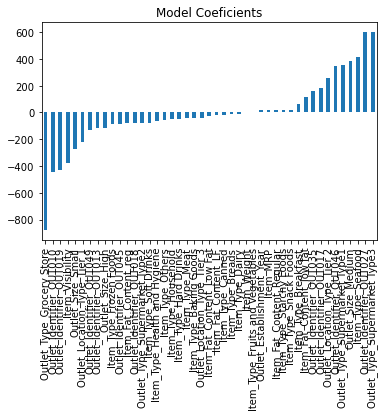

In [17]:
coef = pd.Series(lreg.coef_, x_train.columns).sort_values()
coef.plot(kind='bar', title= "Model Coeficients")

Claramente pode ser observado que alguns coeficientes estão em escala muito superior aos demais. Isso indica que Y é mais dirigido por esses itens. A seguir vamos discutir algumas técnicas de regressão que podem ser aplicadas a estes coeficientes para redução de magnitude.

### Ridge (Cume) Regression (É linear segundo o sklearn)

Segundo a documentação do sklearn, essa regreção deixa o modelo mais robusto contra colinearidade. Isso é controlado pelo alpha, que pode ser maior que 0. No nosso caso, como esse problema não é persistente, acredito que iremos trabalhar com alphas pequenos.

No caso, no artigo que eu estava lendo, o cara mostrou que quanto maior o alfa menor será a magnitude dos coeficientes. Ele mostrou que o alfa 0.05 é o alfa de menor erro para esse caso. 

Então qual lição eu tiro. Hiperparametrização tem que ser testado caso a caso. No nosso caso apesar dos coeficientes terem uma magnitude ainda alta com alfa 0.05, o menor erro foi para esse alfa. Nesse caso, é o que devemos considerar. Se o problema fosse colinearidade, também seria possível aplicar a mesma técnica para ajudar a resolver o problema.

A função de custo para a Ridge Regression é:

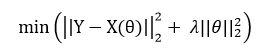

Via de comparação eu vou lembrar qual a função custo que estava sendo utilizada no modelo linear.

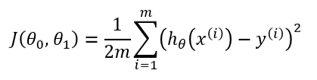

Que é o mesmo que:

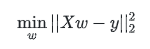

O que é importante notar é que o primeiro componente da Ridge Regression é a função custo da Linear Regression

Considerando y como um vetor. X como uma matriz, e w como um vetor. Temos por Xw - y, a diferença da predição pelo valor real. Aplicando || ||_{2} nisso, teremos a norma euclidiana desse erro, dado pelo somatório dos termos ao quadrado. 

https://lamfo-unb.github.io/2020/02/07/O-M%C3%A9todo-dos-M%C3%ADnimos-Quadrados-Ordin%C3%A1rios-e-Regress%C3%A3o-Linear-Simples/


### Least Absolute Shirnkage Selector Operator Regression (Lasso Regression)

A regressão Lasso, seleciona alguns coeficientes para manter a magnitude (Os coeficientes que são mais importante do modelo), e faz os demais coeficientes tenderem a zero. Ela é dada pela função objetivo a seguir:

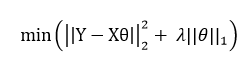

In [18]:
from sklearn.linear_model import Lasso, Ridge
columns = list(train_data.columns)
columns.remove("Item_Outlet_Sales")
x_train = train_data[columns]
y_train = train_data["Item_Outlet_Sales"]
x_test = validation_data[columns]
y_test = validation_data["Item_Outlet_Sales"]

lreg = Ridge(alpha = 0.05, normalize= True)
lreg.fit(x_train,y_train)
prediction = lreg.predict(x_test)

mean_squared_error(prediction,y_test)**(0.5), lreg.score(x_test,y_test)

(1152.065269043734, 0.5402280546106666)

<AxesSubplot:title={'center':'Model Coeficients'}>

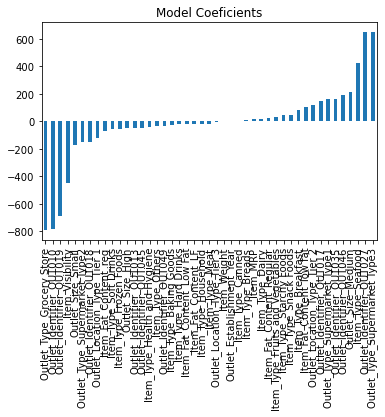

In [19]:
coef = pd.Series(lreg.coef_, x_train.columns).sort_values()
coef.plot(kind='bar', title= "Model Coeficients")

In [28]:
columns = list(train_data.columns)
columns.remove("Item_Outlet_Sales")
x_train = train_data[columns]
y_train = train_data["Item_Outlet_Sales"]
x_test = validation_data[columns]
y_test = validation_data["Item_Outlet_Sales"]

lreg = Lasso(alpha = 0.3, normalize= True)
lreg.fit(x_train,y_train)
prediction = lreg.predict(x_test)

mean_squared_error(prediction,y_test)**(0.5), lreg.score(x_test,y_test)

(1148.3505042916563, 0.5431882879941532)

<AxesSubplot:title={'center':'Model Coeficients'}>

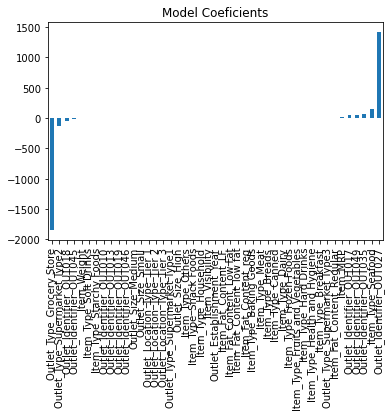

In [29]:
coef = pd.Series(lreg.coef_, x_train.columns).sort_values()
coef.plot(kind='bar', title= "Model Coeficients")

### Em Suma

Ridge Regression diminui a magnitude geral, enquanto Lasso Regression diminiu a magnitude dos coeficientes menos significantes. Acredito que a primeira é melhor para situações mais homogeneas, já a segunda, cabe bem para nossos dados.

Ridge regression faz uso de <b>regularização L2</b>, enquanto a Lasso usa <b>L1</b>. Além disso a <b>regressão Lasso é usada quando existem muitas características no modelo</b>. 

#### O problema surge

O problema surge quando existe uma quantidade muito grande de atributos, como 10k.

Se usarmos a regressão Ridge, teremos a diminuição de magnitude, mas o modelo <b>continuará sendo demasiadamente complexo</b>.
Se aplicarmos Lasso, <b>se tivermos variáveis correlacionadas, estas serão zeradas</b>, ocasionando perca de informação.

Nesse caso, entramos com um outro exemplo de regressão linear, a <b> regressão de rede elástica</b>

### Elastic Net Regression

Esta regressão é dada pela seguinte função objetivo:

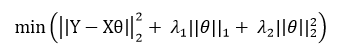

Fica claro que só adicionamos os dois fatores (Dois tipos de regularização, L1 e L2), da Lasso e da Ridge, a regressão linear.

In [35]:
from sklearn.linear_model import ElasticNet
columns = list(train_data.columns)
columns.remove("Item_Outlet_Sales")
x_train = train_data[columns]
y_train = train_data["Item_Outlet_Sales"]
x_test = validation_data[columns]
y_test = validation_data["Item_Outlet_Sales"]

lreg = ElasticNet(alpha = 1, l1_ratio=.5, normalize= False)
lreg.fit(x_train,y_train)
prediction = lreg.predict(x_test)

mean_squared_error(prediction,y_test)**(0.5), lreg.score(x_test,y_test)

(1262.147940518975, 0.4481655297481869)

<AxesSubplot:title={'center':'Model Coeficients'}>

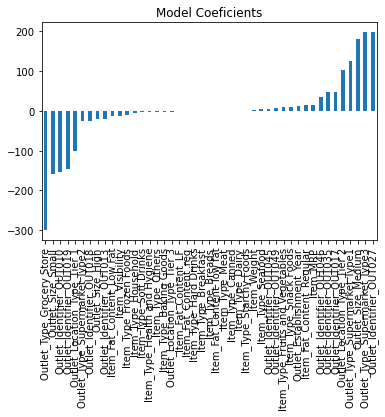

In [36]:
coef = pd.Series(lreg.coef_, x_train.columns).sort_values()
coef.plot(kind='bar', title= "Model Coeficients")

### Desempenho ruim

O desempenho foi muito ruim usando essa regressão... Por mais que brinquemos com os parâmetros não vamos melhorar.
Isso acontece pelo simples motivo de que não existe uma grande quantidade de atributos. 

Observou-se também que a magnitude geral dos coeficientes diminuiu, e alguns foram zerados.

### Hiperparâmetros

Alpha = AlphaL1 + AlphaL2
l1_ratio = AlphaL1/Alpha

Se Alpha = 1, então:
1. Se l1_ratio = 1, temos AlphaL1 = Alpha = 1. Logo, AlphaL2 = 0. (LASSO)
2. Se l1_ratio = 0, AlphaL1 = 0, e por tanto AlphaL2 = 1. (RIDGE)

Logo, l1_ratio entre \[0,1\] temos uma combinação de LASSO e RIDGE.

### Regularização.

O que a regularização faz nos dados exatamente ? 
Já discutimos sobre a redução de magnitude, mas é interessante ver uma representação gráfica do que as regularizações estão fazendo.

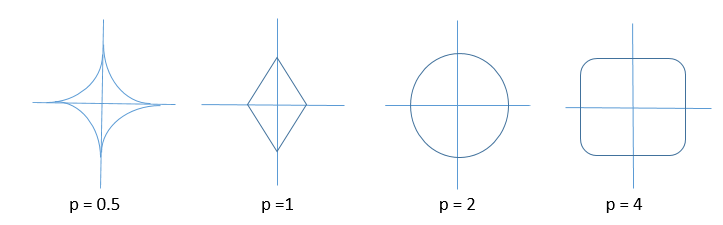

O p, nesse caso é da dita regularização Lp, que é uma abstração das demais apresentadas. Temos:

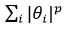

Assim, percebemos que L1, é a soma dos absolutos de Theta, e L2, a soma dos quadrados de Theta.